In [137]:
import pandas as pd
import numpy as np

from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id,udf
from pyspark.sql.types import *
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import MeanShift, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

import constant
import tools

# Load Data

In [2]:
def _load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def _load_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = _load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def _load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


def load_files():
    windmill = _load_csv(constant.windmill_path, constant.windmills_schema)
    windmill = windmill.where("grid != 0").fillna(0.1)
    return windmill

# Clustering Method

In [144]:
def spectral_clustering(df, features, k):
    data = df[features]
    data = StandardScaler().fit_transform(data)
    sc = SpectralClustering(n_clusters=k, random_state=1, n_init=10)
    clusters = sc.fit_predict(data)

    silhouette_avg = silhouette_score(data, clusters)
    print(silhouette_avg)
    return pd.DataFrame(clusters).rename({0:'cluster'},axis=1)

In [145]:
def meanshift(df, features):
    data = df[features]
    data = StandardScaler().fit_transform(data)
    sc = MeanShift()
    clusters = sc.fit_predict(data)

    silhouette_avg = silhouette_score(data, clusters)
    print(silhouette_avg)
    return pd.DataFrame(clusters).rename({0:'cluster'},axis=1)

In [108]:
def append_cluster(df, cluster_df,label):
    return pd.merge(df,cluster_df,left_index=True,right_index=True).rename({'cluster':label},axis=1)

In [121]:
windmills = pd.read_csv('data/windmill_cleaned.csv')
type_udf = lambda x: {"H": 1.0, "W": 2.0, "P": 3.0, "M": 4.0}.get(x, 0.0)
placement_udf = lambda x: {"LAND": 1.0, "HAV": 2.0}.get(x, 0.0)

In [122]:
windmills['Turbine_type'] = windmills['Turbine_type'].apply(type_udf)
windmills['Placement'] = windmills['Placement'].apply(placement_udf)
windmills = windmills.fillna(-1)

In [132]:
windmills_LP = windmills[windmills['Placement']==1.0][windmills['Turbine_type']==3.0].reset_index().drop('index', axis=1)
windmills_LW = windmills[windmills['Placement']==1.0][windmills['Turbine_type']==2.0].reset_index().drop('index', axis=1)
windmills_HP = windmills[windmills['Placement']==2.0][windmills['Turbine_type']==3.0].reset_index().drop('index', axis=1)
windmills_HW = windmills[windmills['Placement']==2.0][windmills['Turbine_type']==2.0].reset_index().drop('index', axis=1)

## LP

In [158]:
windmills_LP = windmills_LP[windmills_LP['Capacity_kw']>0]

In [159]:
feat_cols = ["Capacity_kw", "roughness"]
clusters = spectral_clustering(windmills_LP, feat_cols, 10)

0.6539514543149344


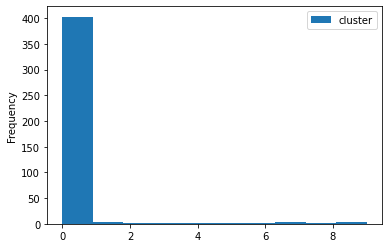

In [160]:
clusters.plot.hist()

In [134]:
windmills_LP = append_cluster(windmills_LP, clusters, 'cls_g')

# HP

In [161]:
windmills_HP = windmills_HP[windmills_HP['Capacity_kw']>0]

In [169]:
feat_cols = ["Capacity_kw", "roughness"]
clusters = spectral_clustering(windmills_HP, feat_cols, 2)

0.6769987721429905


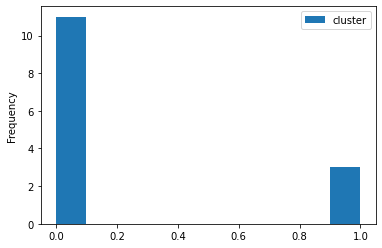

In [173]:
clusters.plot.hist()

In [167]:
windmills_HP = append_cluster(windmills_HP, clusters, 'cls_g')

# LW

In [180]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height", "roughness"]
clusters = spectral_clustering(windmills_LW, feat_cols, 6)

0.7223512799177714


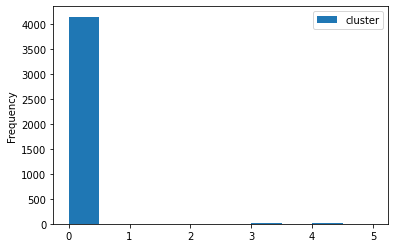

In [181]:
clusters.plot.hist()

In [183]:
windmills_LW = append_cluster(windmills_LW, clusters, 'cls_g')

# HW

In [187]:
feat_cols = ["Capacity_kw", "Rotor_diameter", "Navhub_height", "roughness"]
clusters = spectral_clustering(windmills_HW, feat_cols, 6)

0.7769124310089568


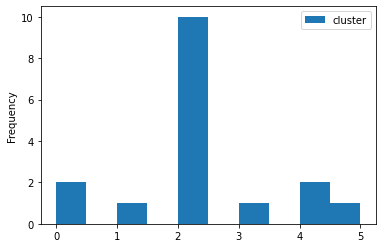

In [188]:
clusters.plot.hist()

In [190]:
windmills_HW = append_cluster(windmills_HW, clusters, 'cls_g')

In [191]:
windmills_HW


,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,grid,grid_in_range,Land_cover,Slope,roughness,cls_g
0,570715000000057465,2.0,-1.0,813.0,2.0,593639.0,6368280.0,2300.0,82.4,80.0,1124,"1123,1168,1167,1164,1122,1165,1039,1080,1166,1...",210.0,2.024868,0.0,4
1,570715000000057472,2.0,-1.0,813.0,2.0,593839.5,6368078.1,3000.0,90.0,80.0,1124,"1123,1167,1164,1122,1165,1039,1080,1166,1038,1...",210.0,0.000000,0.0,3
2,570715000000057489,2.0,-1.0,813.0,2.0,594040.0,6367875.6,2300.0,90.0,80.0,1124,"1123,1167,1164,1122,1165,1039,1080,1166,1038,1...",210.0,-1.000000,0.0,4
3,570715000000062926,2.0,-1.0,741.0,2.0,599506.0,6177761.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,-1.000000,0.0,2
4,570715000000062933,2.0,-1.0,741.0,2.0,599513.0,6177461.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,-1.000000,0.0,2
5,570715000000062940,2.0,-1.0,741.0,2.0,599520.0,6177160.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,-1.000000,0.0,2
6,570715000000062957,2.0,-1.0,741.0,2.0,599527.0,6176860.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,-1.000000,0.0,2
7,570715000000062964,2.0,-1.0,741.0,2.0,599533.0,6176559.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,-1.000000,0.0,2
8,570715000000062971,2.0,-1.0,741.0,2.0,599540.0,6176259.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,-1.000000,0.0,2
9,570715000000062988,2.0,-1.0,741.0,2.0,599547.0,6181039.0,2300.0,84.6,61.2,945,"985,1028,986,1030,943,1029,860,902,944,945,987...",210.0,0.000000,0.0,2
